In [1]:
from sqlalchemy import create_engine
import json

import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
engine = create_engine('sqlite:///tab.db')
conn = engine.connect()
conn
dfo = pd.read_sql_table('race', conn)
print('{} races loaded!'.format(len(dfo)))
dfo = dfo.loc[dfo['race_type'].isin(['R'])]
print('{} horse races!'.format(len(dfo)))

7306 races loaded!
2426 horse races!


In [3]:
dfo['results'] = dfo['results_data'].map(json.loads)
dfo['runners'] = dfo['runners_data'].map(json.loads)
dfo.describe()

,id,race_number,race_distance,num_runners
count,2426.000000,2426.000000,2426.00000,2426.000000
mean,4393.744023,4.654575,1658.82028,9.610058
std,1977.221171,2.498538,758.13690,2.912123
min,1610.000000,1.000000,790.00000,3.000000
25%,2446.250000,3.000000,1200.00000,7.000000
50%,4297.500000,5.000000,1400.00000,9.000000
75%,6151.750000,7.000000,1800.00000,12.000000
max,7857.000000,12.000000,6400.00000,22.000000


In [4]:
# bet size
balance = 1000
bet_chunk = balance * 0.05

In [23]:
def process_strategy(df, strategy):
    """run strategy, must pass runners returned back into results (it might be modified)"""

    book = []
    for _, race in dfo.iterrows():
#         print(race['num_runners'])

        runners = race['runners']

        runners, num_bets = strategy(runners, bet_chunk)
#         except KeyError:
#             continue

        bet_results(book, runners, race['num_runners'], bet_chunk, num_bets, race['race_type'])

    return book

In [6]:
def bet_results(book, runners, num_runners, bet_chunk, num_bets, race_type):
    """get results from bets"""
    num_runners = num_runners
    win_diff = 0
    max_diff = 0
    outcome = {
        'success': 0,
        'profit': -bet_chunk,
        'num_bets': num_bets,
        'num_runners': num_runners,
    }
    for i, runner in enumerate(runners):
        diff = abs(runner['odds_scale'] - runner['probability'])
        max_diff = max(max_diff, diff)
        if int(runner['finishingPosition']) == 1:
            win_diff = diff
            if runner['bet'] > 0:
                odds = runner['parimutuel']['returnWin'] if runner['parimutuel']['returnWin'] else runner['odds_win']
                profit = runner['bet'] * odds - bet_chunk
                outcome = {
                    'success': 1,
                    'profit': profit,
                    'num_bets': num_bets,
                    'num_runners': num_runners,
                }
            break

    outcome['max_diff'] = max_diff
    outcome['win_diff'] = win_diff
    outcome['bet_chunk'] = bet_chunk
    outcome['race_type'] = race_type
    outcome['runners'] = runners
    book.append(outcome)

In [21]:
def bettable(r):
    return (r['probability'] > r['odds_scale'] and r['odds_win'] > 0)

In [22]:
def bet_positive_only(runners, bet_chunk):
    """if prob > odds, bet"""
    
    # total (only of runners we are betting on)
    all_odds_scaled = [r['odds_scale'] for r in runners if bettable(r)]
    all_probs = [r['probability'] for r in runners if bettable(r)]
    total_scaled = sum(all_odds_scaled)
    total_probs = sum(all_probs)

    num_bets = len(all_odds_scaled)
    
    for runner in runners:
#         runner['bet'] = runner['odds_scale'] / total_scaled * bet_chunk if bettable(runner) else 0
        runner['bet'] = runner['probability'] / total_probs * bet_chunk if bettable(runner) else 0

    return runners, num_bets


dfo = dfo.sample(frac=1).reset_index(drop=True)
print('Dataframe shuffled!')

book = process_strategy(dfo, bet_positive_only)

Dataframe shuffled!


In [ ]:
def bet_positive_dutch(runners, bet_chunk):
    """dutch betting on probability"""

    # drop scratched
    runners = [r for r in runners if bettable(r)]

    # sort runners from favourite to underdog
    runners.sort(key=itemgetter('probability'), reverse=True)

    # start betting on all and cut off worse runner till positive outcome
    for num_bets in range(len(runners), 0, -1):

        # reset bets for all
        for runner in runners:
            runner['bet'] = 0

        pool = runners[:num_bets]

        # all odds
        total = sum([r['probability'] for r in pool])

        # dutch for all in pool
        for runner in pool:
            runner['bet'] = runner['probability'] / total * bet_chunk
            odds = runner['parimutuel']['returnWin'] if runner['parimutuel']['returnWin'] else runner['odds_win']
            profit = runner['bet'] * odds - bet_chunk

        # exit when profitable
        pp = profit / bet_chunk
        if profit > 0:
            logger.info('profitable!')
            break
        else:
            logger.info('nope, try again!')

    return pool, num_bets

In [8]:
df = pd.DataFrame(book)
df.tail(10)

,bet_chunk,max_diff,num_bets,num_runners,profit,race_type,runners,success,win_diff
2416,50.0,0.030098,2,4.0,-4.441035,R,"[{'riderDriverName': 'R JOHNSON', 'claimAmount...",1,0.030098
2417,50.0,0.090210,12,12.0,-23.347349,R,"[{'riderDriverName': 'JAKE NOONAN', 'claimAmou...",1,0.035521
2418,50.0,0.006710,3,9.0,-50.000000,R,"[{'riderDriverName': 'G MOSSE', 'claimAmount':...",0,0.003757
2419,50.0,0.040655,3,6.0,14.279512,R,"[{'riderDriverName': 'ANNA PILROTH', 'claimAmo...",1,0.040655
2420,50.0,0.024761,4,8.0,16.411186,R,"[{'riderDriverName': 'ASHLEY BUTLER', 'claimAm...",1,0.010400
2421,50.0,0.011036,1,7.0,-50.000000,R,"[{'riderDriverName': 'HUGO HERRERA', 'claimAmo...",0,0.011036
2422,50.0,0.015764,3,9.0,25.986633,R,"[{'riderDriverName': 'C MURRAY', 'claimAmount'...",1,0.015764
2423,50.0,0.010979,3,9.0,42.961653,R,"[{'riderDriverName': 'A FOUASSIER', 'claimAmou...",1,0.003991
2424,50.0,0.085768,14,14.0,3.281479,R,"[{'riderDriverName': 'MICHAEL DEE', 'claimAmou...",1,0.085768
2425,50.0,0.029306,11,11.0,-19.153643,R,"[{'riderDriverName': 'K M DONOGHUE', 'claimAmo...",1,0.006328


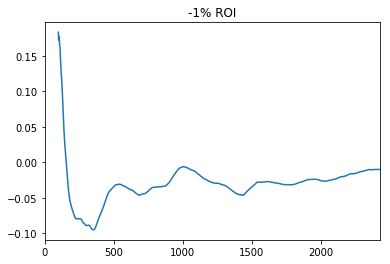

In [9]:
# ROI
roi = df.profit.cumsum() / df.bet_chunk.cumsum()
roi_title = '{:.0f}% ROI'.format(roi.iloc[-1] * 100)
roi.rolling(100).mean().plot(title=roi_title)

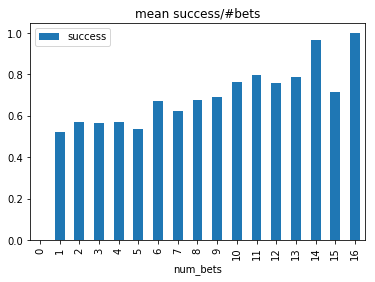

In [10]:
# profit per num bets 
groups = df.groupby('num_bets').mean()
groups.plot(kind='bar', y='success', title='mean success/#bets')

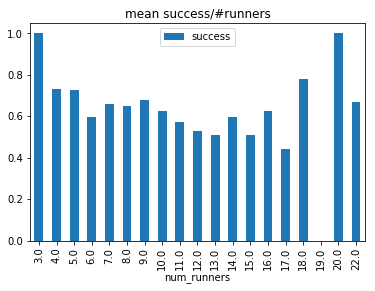

In [11]:
# profit per num runners
groups = df.groupby('num_runners').mean()
groups.plot(kind='bar', y='success', title='mean success/#runners')

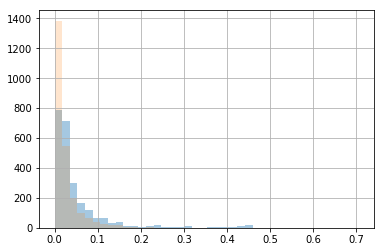

In [12]:
# max diff
df.max_diff.hist(bins=40, alpha=.4)
df.win_diff.hist(bins=40, alpha=.2)

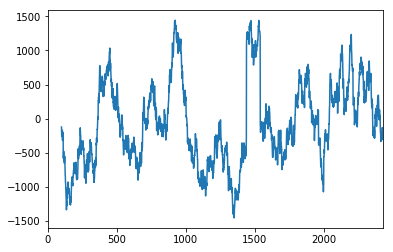

In [13]:
df.profit.rolling(100).sum().plot()

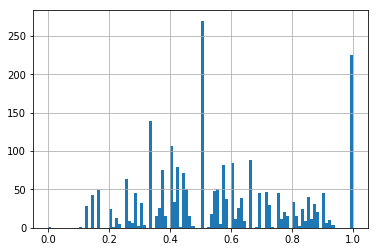

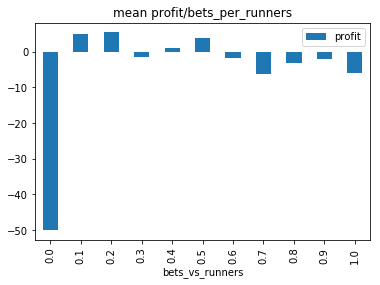

In [19]:
# bets/runners
df['bets_vs_runners'] = df.num_bets / df.num_runners
df['bets_vs_runners'].hist(bins=100)
groups = df.groupby(df['bets_vs_runners'].apply(lambda x: round(x, 1))).mean()
groups.plot(kind='bar', y='profit', title='mean profit/bets_per_runners')